In [1]:
import pynbody
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
galaxy_masses=pd.DataFrame()
BH_halos=pd.DataFrame()
snap_id=0

In [43]:
def loader(path):
    '''returns snapshot and halo'''
    snap=pynbody.load(path)
    snap.physical_units()
    h=snap.halos()
    return snap,h

def BH_finder(snap):
    '''returns subsnap of black holes'''
    return snap.star[pynbody.filt.BandPass('tform','-15 Gyr','0 Gyr')]

def analysis(halo, view):
    '''center snap on halo's center of mass (angmom gives errors if there aren't enough pixels). 
    view=1 for face on, 2 for side on, anything else will leave it as is'''
    if view==1:
        pynbody.analysis.angmom.faceon(halo)
    elif view==2:
        pynbody.analysis.angmom.sideon(halo)
    else:
        pynbody.analysis.halo.center(halo)
        
def plot_BH_pos(h, BH, grpid, attribute, snap_id, cmap='Greys', w=100, save=False, view=0):
    '''plots position of black holes. Send halo array(h), black hole array(BH), grpid, attribute, and snap_id you want to plot 
    Optional: width/preferred scope(w) (default=100), colormap(default='Greys'), save(default=False)'''
    
    pynbody.plot.image(h[grpid].s,qty=attribute,cmap=cmap, width=w, log=False)
    plt.plot(np.array((BH[np.where(BH['amiga.grp']==grpid)]['pos'])).T[0],np.array((BH[np.where(BH['amiga.grp']==grpid)]['pos'])).T[1],'r+')
    plt.xlim(-w/2,w/2)
    plt.ylim(-w/2,w/2)
    plt.title('%s_h%s_%s_w%s'%(snap_id, grpid, attribute, w))
    if save==True:
        plt.savefig('plots/%s/h%s/h148_h%s_%s_w%s.png'%(snap_id, grpid, grpid, attribute, w))
    plt.show()

def adjust_csv_index(df):
    df=df.rename(columns={'Unnamed: 0':'snap'})
    df=df.set_index('snap')
    
def add_mass_columns(hgrpid, grpid, snap_id):
    '''returns row with gas, stellar, and total masses for one halo tracked through time'''
    df=pd.DataFrame([[hgrpid.g['mass'].sum(), hgrpid.s['mass'].sum(), hgrpid['mass'].sum()]], index=[snap_id], columns=['H[%d] Gas'%(grpid),'H[%d] Star'%(grpid),'H[%d] Total'%(grpid)])
    df.units='Msol'
    return df
    
def mass_df(h, BHgrp, snap_id):
    df=pd.DataFrame()
    for i in BHgrp:
        df=pd.concat([df, add_mass_columns(h[i], i, snap_id)], axis=1, join='outer')
    df.units='Msol'
    return df
    
def galaxy_df(snap_id,h,BHgrp):
    '''snap_id_array[snap_id], h, np.unique(BH['amiga.grp'])'''
    galaxy_masses=pd.DataFrame()
    for i in snap_id:
        vars()['mass_%s'%(i)]=mass_df(h,BHgrp,i)
        galaxy_masses=galaxy_masses.append(vars()['mass_%s'%(i)])
    return galaxy_masses
    if save==True:
        galaxy_masses.to_csv('csvdata/%s_galaxy_masses.csv'%(snap_id))        
    
def plot_SFH(h, grpid, snap_id, ls='dashed', c='k', save=True, mf=False):
    '''plots SFH. Send halo array(h[grpid]), linestyle(ls=dashed), color(c=k) grpid, and snapshot you want to plot 
    Optional:save(default=True)
    #examples of iterative SFH:
    for i in np.unique(BH['amiga.grp']): #using black hole array
        plot_SFH(h,i,snap_id_array[snap_id], mf=False)
    for i in np.unique(iords[str(snap_id_array[snap_id])+' halo groups'].dropna()): #using iords array
        plot_SFH(h,i,snap_id_array[snap_id], mf=False)'''
    plt.clf()
    pynbody.plot.sfh(h[grpid].s,linestyle=ls,color=c, massform=mf);
    plt.title('%s_h[%s]_SFH'%(snap_id,grpid), y=1.14);
    if save==True:
        plt.savefig('plots/SFH/%s_h[%s]_SFH.png'%(snap_id, grpid),bbox_inches='tight');

def BH_halo_add(snap_id, BH, BH_halos):
    '''snap_id_array[snap_id], BH, BH_halos'''
    df=pd.DataFrame({'%s halo groups'%(snap_id):BH['amiga.grp'],'%s iords'%(snap_id):BH['iord']})
    BH_halos=pd.concat([BH_halos, df], axis=1, join='outer')
    return BH_halos

def load_snap_csvs(snap_id):
    '''snap_id_array[snap_id]. load mass and iord csvs'''
    masses=pd.DataFrame()
    masses=pd.read_csv('csvdata/%s_galaxy_masses.csv'%(snap_id),index_col='snap')
    vars()['snap%s_iords'%(snap_id)]=pd.DataFrame()
    vars()['snap%s_iords'%(snap_id)]=pd.read_csv('csvdata/%s_iords.csv'%(snap_id),index_col='snap')
    return masses,vars()['snap%s_iords'%(snap_id)]
    
def get_iords_df(iords, iords_list, masses, save=False):
    for i in iords_list:
        ind=0
        vars()['iord_%s'%(i)]=pd.DataFrame(columns=['gas', 'star', 'total'])
        iords_temp=iords[i].dropna()
        vars()['iord_%s'%(i)]['halo']=iords[i]
        for j in iords_temp.index:
            if pd.notnull(iords.at[j,i]):
                temp=[masses.at[j,'H[%s] Gas'%(int(iords.at[j,i]))],masses.at[j,'H[%s] Star'%(int(iords.at[j,i]))],masses.at[j,'H[%s] Total'%(int(iords.at[j,i]))]]
            if (pd.notnull(temp)).any():
                vars()['iord_%s'%(i)].loc[int(iords_temp.index[ind]),['gas','star','total']]=temp
            else: continue
            ind=ind+1
            vars()['iord_%s'%(i)]=vars()['iord_%s'%(i)].fillna(0)
            if save==True:
                vars()['iord_%s'%(i)].to_csv('csvdata/iord_%s.csv'%(i))
                
def iord_mass_plot(iord_df,iords_list,save=False):
    for i in range(0,len(iords_list)):
        x=iords_list[i]
        plt.hist(range(0,len(iord_df)), weights=iord_df['total'], bins=len(iord_df),width=.85, alpha=.3, histtype='bar', label='Total', color='#666666',rwidth=1, align='mid')
        plt.hist([range(0,len(iord_df)),range(0,len(iord_df))], weights=[iord_df['gas'],iord_df['star']],bins=len(iord_df),width=.85, alpha=1, histtype='bar', stacked=True, label=['Gas','Stars'],fill=True, color=['#44AA99','#88CCEE'],rwidth=1,align='mid')
        plt.title('Masses of Halo Containing iord %s'%(x));
        plt.ylabel('Mass [M$_\odot$]', fontsize='large');
        plt.legend(loc='best')
        plt.yscale('log')
        if save==True:
            plt.savefig('plots/galaxy_masses/iord_%s_masses.png'%(x),bbox_inches='tight')


In [4]:
#array of last four digits for each snap
snap_id_array=['0139','0225','0275','0640','0974','1024','1269','1280','1408','1740','2048','2088','2432','2688','2816','2944','3072','3195','3200','3328','3456','3584','3606','3712','3840','3968','4096']

In [5]:
#snap id index (negative values start from end)
snap_id=snap_id-1
snap_id_array[snap_id]

'4096'

In [6]:
#set path
path='/data/scratch/jillian/h148/h148.cosmo50PLK.3072g3HbwK1BH.00%s/h148.cosmo50PLK.3072g3HbwK1BH.00%s'%(snap_id_array[snap_id],snap_id_array[snap_id])

In [7]:
#returns snapshot and halos in physical units (takes a couple of minutes)
snap,h=loader(path)

In [38]:
masses,vars()['snap%s_iords'%(snap_id_array[snap_id])]=load_snap_csvs(snap_id_array[snap_id])
vars()['snap%s_iords_list'%(snap_id_array[snap_id])]=vars()['snap%s_iords'%(snap_id_array[snap_id])].columns.tolist()
for i in vars()['snap%s_iords_list'%(snap_id_array[snap_id])]:
    vars()['snap%s_iord_%s'%(snap_id_array[snap_id],i)]=pd.read_csv('csvdata/%s_iord_%s.csv'%(snap_id_array[snap_id],i),index_col='snap')

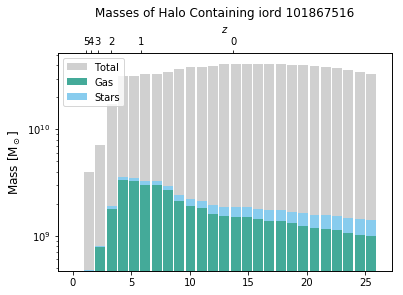

In [52]:
x=vars()['snap%s_iords_list'%(snap_id_array[snap_id])][15]
bins=len(vars()['snap%s_iord_%s'%(snap_id_array[snap_id], x)])

trange = [snap.s['tform'].in_units("Gyr").min(), snap.s['tform'].in_units("Gyr").max()]
binnorm = 1e-9 * bins / (trange[1] - trange[0])
trangefilt = pynbody.filt.And(pynbody.filt.HighPass('tform', str(trange[0]) + ' Gyr'),pynbody.filt.LowPass('tform', str(trange[1]) + ' Gyr'))
tforms = snap.s[trangefilt]['tform'].in_units('Gyr')

plt.hist(range(0,len(vars()['snap%s_iord_%s'%(snap_id_array[snap_id],i)])), weights=vars()['snap%s_iord_%s'%(snap_id_array[snap_id], x)]['total'], bins=bins,width=.85, alpha=.3, histtype='bar', label='Total', color='#666666',rwidth=1, align='mid')
plt.hist([range(0,len(vars()['snap%s_iord_%s'%(snap_id_array[snap_id], x)])),range(0,len(vars()['snap%s_iord_%s'%(snap_id_array[snap_id], x)]))], weights=[vars()['snap%s_iord_%s'%(snap_id_array[snap_id], x)]['gas'],vars()['snap%s_iord_%s'%(snap_id_array[snap_id], x)]['star']],bins=bins,width=.85, alpha=1, histtype='bar', stacked=True, label=['Gas','Stars'],fill=True, color=['#44AA99','#88CCEE'],rwidth=1,align='mid')
plt.title('Masses of Halo Containing iord %s'%(x), y=1.14);
plt.ylabel('Mass [M$_\odot$]', fontsize='large');
plt.legend(loc='best')
plt.yscale('log')

x0, x1 = plt.gca().get_xlim()
from pynbody.analysis import pkdgrav_cosmo as cosmo
c = cosmo.Cosmology(snap)
old_axis = plt.gca()

if len(plt.gcf().axes)<2:
    pz = plt.twiny()
    labelzs = np.arange(5, int(snap.properties['z']) - 1, -1)
    times = [13.7 * c.Exp2Time(1.0 / (1 + z)) / c.Exp2Time(1) for z in labelzs]
    pz.set_xticks(times)
    pz.set_xticklabels([str(x) for x in labelzs])
    pz.set_xlim(-.5, x1)
    pz.set_xlabel('$z$')
    plt.sca(old_axis)

In [57]:
x0, x1

(-1.3000000000000003, 27.300000000000004)